In [4]:
%pip install transformers
%pip install sentencepiece
%pip install torchvision


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
model.eval()


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [6]:
import pandas as pd

sandbox_train_dir = Path("sandbox/train_sample")
output_csv = Path("sandbox/sandbox_generated_captions.csv")

captions = []

for img_path in tqdm(list(sandbox_train_dir.glob("*.jpg"))):
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = processor(image, return_tensors="pt").to(device)

        out = model.generate(**inputs, max_length=50)
        caption = processor.decode(out[0], skip_special_tokens=True)

        captions.append({
            "ImageId": img_path.stem,
            "Caption": caption
        })

    except Exception as e:
        print(f"Error on {img_path.name}: {e}")

# Save to CSV
captions_df = pd.DataFrame(captions)
captions_df.to_csv(output_csv, index=False)
print(f"Generated {len(captions_df)} captions. Saved to {output_csv}")


100%|██████████| 2000/2000 [1:07:52<00:00,  2.04s/it]


Generated 2000 captions. Saved to sandbox/sandbox_generated_captions.csv


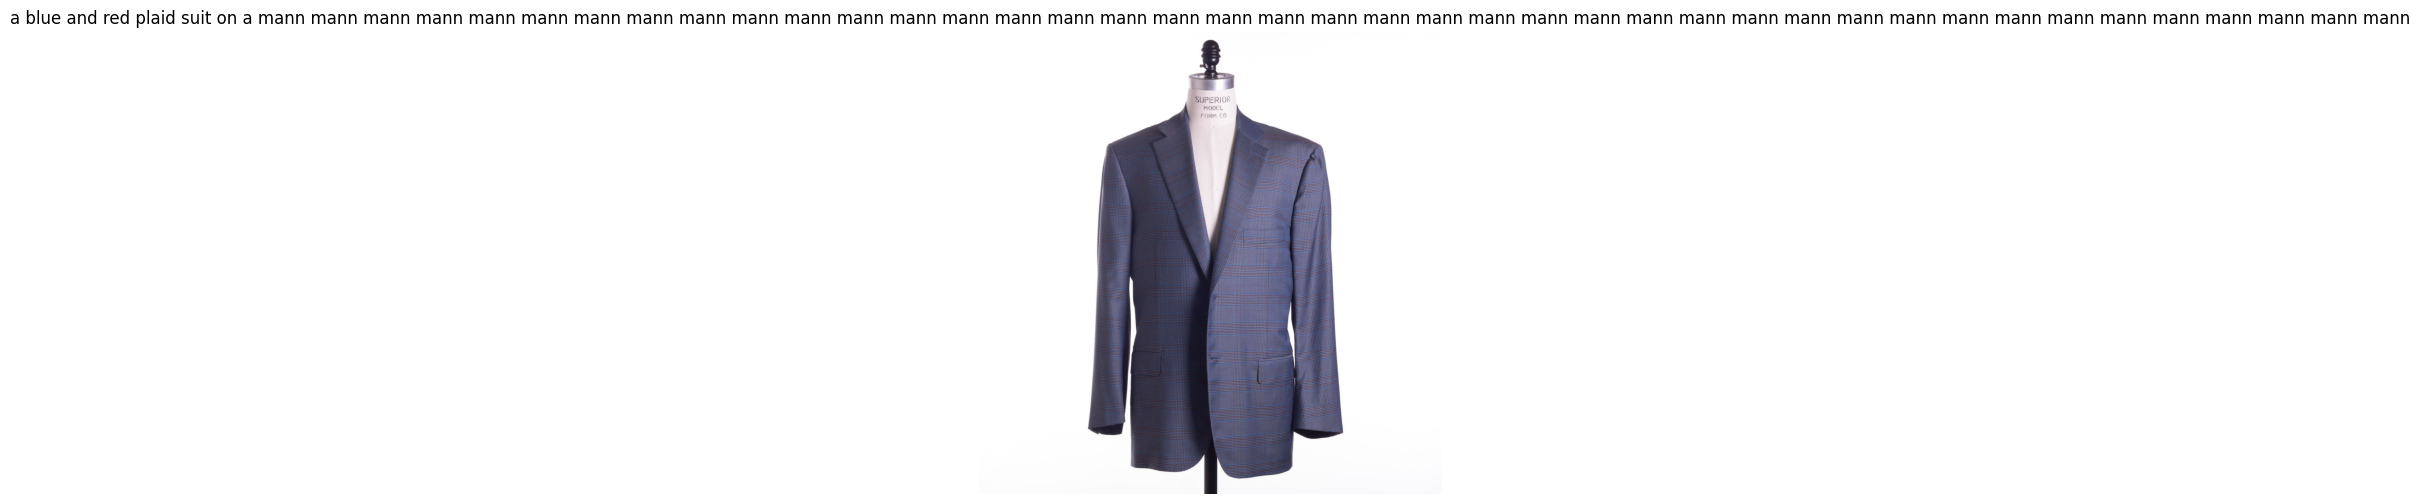

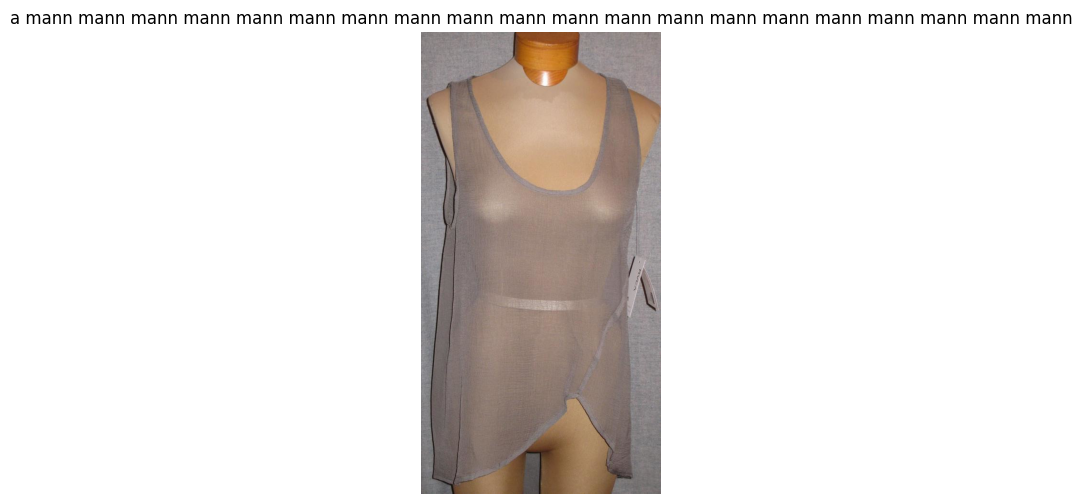

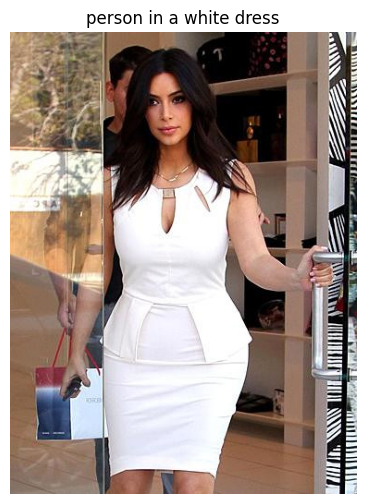

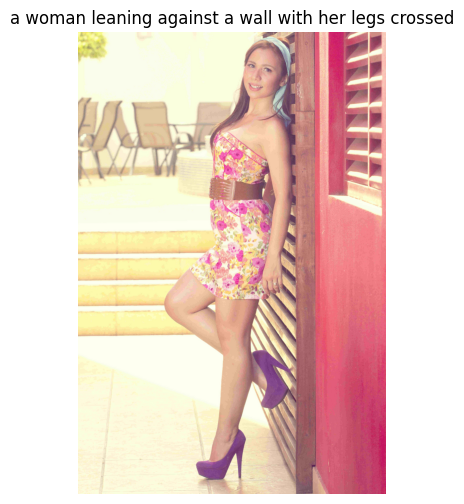

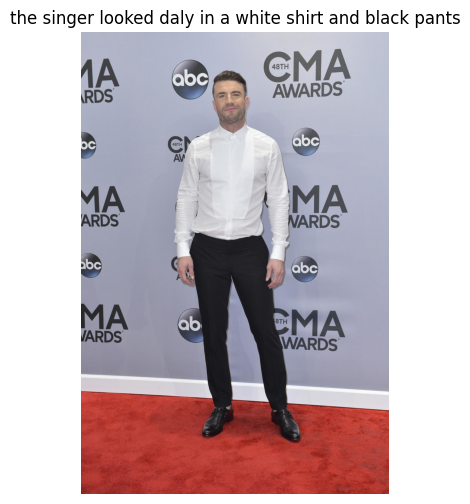

In [7]:
import matplotlib.pyplot as plt
import random

sample = captions_df.sample(5)
for _, row in sample.iterrows():
    img_path = sandbox_train_dir / f"{row['ImageId']}.jpg"
    image = Image.open(img_path)

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"{row['Caption']}")
    plt.axis("off")
    plt.show()
